<a href="https://colab.research.google.com/github/pietroventurini/predict-future-sales/blob/main/Predict_Future_Sales_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the model

In this second notebook, we are going to train a model on the augmented dataset we build in the first part.

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from google.colab import drive
#!pip install shap
import shap
import plotly.express as px
import plotly.graph_objects as go

# Constants
use_drive = True
save_model = False
load_model = True

if use_drive:
  drive_name = '/content/drive'
  drive.mount(drive_name)
  drive_folder = 'Colab Notebooks/Predict Future Sales' # Files location in Google Drive
  drive_location = drive_name + '/My Drive/' + drive_folder + '/'
else:
  drive_location = './'

DATA_PATH = drive_location + 'datasets/data.pkl' 
SUBMISSION_PATH = drive_location + 'datasets/sample_submission.csv'
MODEL_PATH = drive_location + '/datasets/model.txt'

sales = pd.read_pickle(DATA_PATH)

X_train = sales[sales.date_block_num <= 32].drop(['item_cnt_month'], axis=1)
y_train = sales[sales.date_block_num <= 32]['item_cnt_month']
X_valid = sales[sales.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = sales[sales.date_block_num == 33]['item_cnt_month']
X_test = sales[sales.date_block_num == 34].drop(['item_cnt_month'], axis=1)
#y_train = y_train.clip(0, 20)
#y_valid = y_valid.clip(0, 20)

#del sales
#gc.collect()

## LightGBM

[LightGBM](https://lightgbm.readthedocs.io/en/latest/) is a gradient boosting framework (similar to XGBoost) designed to be memory efficient and at the same time fast.

LightGBM uses histogram-based algorithms rather than  pre-sort-based algorithms (which is the default algorithm in XGBoost), which bucket continuous feature values into discrete bins. The main advantages that arise from that are:
- Reduced cost of calculating the gain for each split
- Use histogram subtraction: to get a leaf's histogram, it uses histogram subtraction of its parent and its neighbor.
- Reduced memory usage: replaces continuous values with discrete bins

LightGBM grows trees leaf-wise (best leaf first) rather than level wise.

In [ ]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf': 10,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1,
    'force_row_wise': True
}

categorical_feature_names = ['item_category_id',
                            'section', 
                            'cat_name',
                            'cat_sub_name',
                            'cat_sec_sub_name',
                             'item_name',
                             'item_name_2',
                             'item_name_3',
                            'shop_id',
                            'shop_name',
                            'shop_city',
                             'shop_type',
                             'month',
                             'year']

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=None)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=None, reference=lgb_train)

evals_result = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 4000,
                valid_sets = (lgb_train, lgb_eval),
                feature_name = X_train.columns.tolist(),
                categorical_feature = categorical_feature_names,
                verbose_eval = 100,
                evals_result = evals_result,
                early_stopping_rounds = 150)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[100]	training's rmse: 0.838483	valid_1's rmse: 0.832948
[200]	training's rmse: 0.721924	valid_1's rmse: 0.78841
[300]	training's rmse: 0.674041	valid_1's rmse: 0.782199
[400]	training's rmse: 0.647253	valid_1's rmse: 0.779913
[500]	training's rmse: 0.627835	valid_1's rmse: 0.779727
[600]	training's rmse: 0.613665	valid_1's rmse: 0.779838
[700]	training's rmse: 0.602582	valid_1's rmse: 0.77997
Early stopping, best iteration is:
[554]	training's rmse: 0.61981	valid_1's rmse: 0.779485


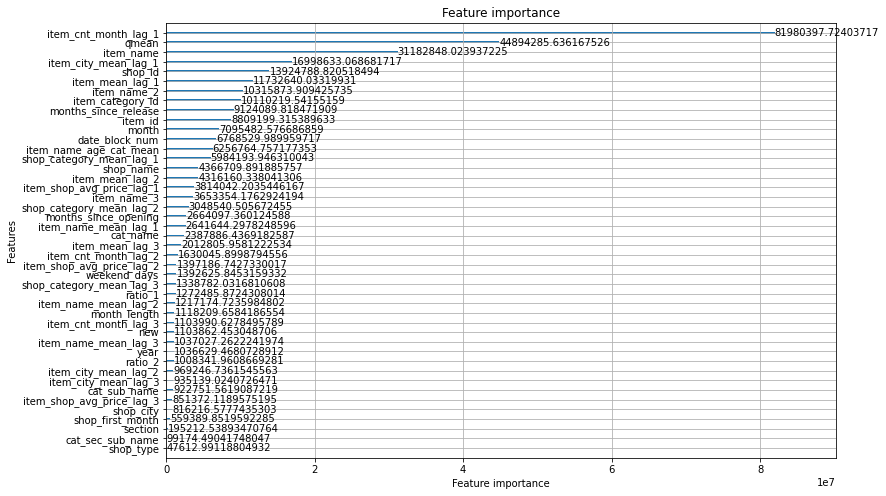

In [ ]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8))

In [ ]:
if save_model:
  gbm.save_model(drive_location + 'datasets/model.txt')

In [ ]:
sample_submission = pd.read_csv(SUBMISSION_PATH, index_col='ID')
sample_submission['item_cnt_month'] = gbm.predict(X_test).clip(0, 20)
sample_submission.to_csv('submission_lgbm_1.csv')

# Model Analyisis

We conclude our analysis by looking at the model performances over the train and the validation set, and we propose possible approaches that may improve its performances. 

The model we trained obtained a score of `0.87590` on the test set, placing around the 400th position over more than 10000 teams (meaning top 4%). For me, that's a considerable results, being this the first time I competed in a machine learning competition.

In [ ]:
if load_model:
  gbm = lgb.Booster(model_file=MODEL_PATH)

In [ ]:
# define behavior
load_rmse: True
save_rmse: False

if not load_rmse:
  X_train['lgb_pred'] = gbm.predict(X_train).clip(0, 20)
  X_train['target'] = y_train
  X_train['sq_err'] = (X_train['lgb_pred'] - X_train['target'])**2

  X_valid['lgb_pred'] = gbm.predict(X_valid).clip(0, 20)
  X_valid['target'] = y_valid
  X_valid['sq_err'] = (X_valid['lgb_pred'] - X_valid['target'])**2

  X_test['lgb_pred'] = gbm.predict(X_test).clip(0, 20)
  data = X_train.groupby('date_block_num').agg({'lgb_pred':'mean', 
                                                'target':'mean', 
                                                'sq_err':'mean'}).reset_index()

  data['new_item_rmse'] = np.sqrt(X_train.query('months_since_release<=1').groupby('date_block_num').agg({'sq_err':'mean'}).reset_index()['sq_err'])
  data['old_item_rmse'] = np.sqrt(X_train.query('months_since_release>1').groupby('date_block_num').agg({'sq_err':'mean'}).reset_index()['sq_err'])
  data = data.append([{'date_block_num': 33,
                      'target': X_valid['target'].mean(),
                      'lgb_pred': X_valid['lgb_pred'].mean(),
                      'sq_err': np.sqrt(X_valid['sq_err'].mean()),
                      'old_item_rmse': np.sqrt(X_valid.query('months_since_release>1')['sq_err'].mean()),
                      'new_item_rmse': np.sqrt(X_valid.query('months_since_release<=1')['sq_err'].mean())
                      },
                      {'date_block_num': 34,
                      'target': 0,
                      'lgb_pred': X_test['lgb_pred'].mean(),
                      'sq_err': 0,
                      'old_item_rmse': 0,
                      'new_item_rmse': 0                      
                      }], ignore_index=True)
  data['date'] = [x[:7] for x in pd.date_range(start='2013-04', end='2015-09', freq='MS').astype('str')] + ['Validation', 'Test']

In [ ]:
if save_rmse:
  # Save computed values
  X_train[['lgb_pred', 'target', 'sq_err']].to_pickle('./train_sq_err.pkl')
  X_valid[['lgb_pred', 'target', 'sq_err']].to_pickle('./valid_sq_err.pkl')
  X_test[['lgb_pred']].to_pickle('./test_sq_err.pkl')
  data.to_pickle('./data_means.pkl')

In [ ]:
if load_rmse:
  # load computed values
  X_train[['lgb_pred', 'target', 'sq_err']] = pd.read_pickle(drive_location+'datasets/train_sq_err.pkl')
  X_valid[['lgb_pred', 'target', 'sq_err']] = pd.read_pickle('./valid_sq_err.pkl')
  X_test[['lgb_pred']] = pd.read_pickle('test_sq_err.pkl')
  data = pd.read_pickle('./data_means.pkl')

Let's plot a summary plot of feature importance. We are going to use a _summary plot_ from a library called [`shap`](https://shap.readthedocs.io/en/latest/).

In the following plot, each dot has three characteristics:
1. Vertical location: which feature it is depicting.
2. Color: whether that feature was high or low for that row of the dataset.
3. Horizontal location: whether the effect of that value caused a higher or lower prediction.

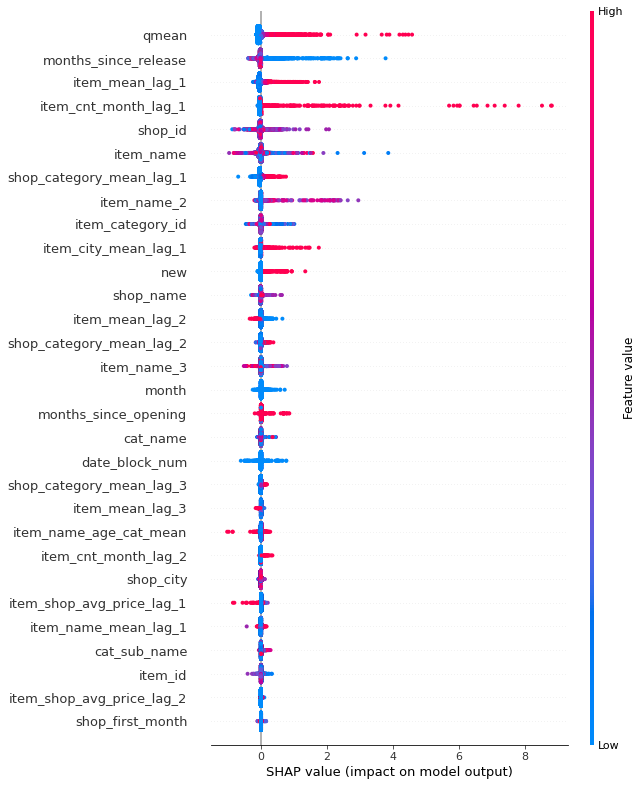

In [ ]:
gbm.params['objective'] = 'regression'
temp = X_test.drop(columns='lgb_pred').sample(10000)
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(temp)
shap.summary_plot(shap_values, temp, max_display=30)

By default the features are ordered using `shap_values.abs.mean(0)`, which is the mean absolute value of the SHAP values for each feature. 
As we can see, the most valuable features are
1. `qmean`
2. `months_since_release`
3. `item_mean_lag_1`
4. `item_cnt_month_lag_1`

We can observe a positive correlation between the predicted monthly sales and `qmean`, as well with `item_mean_lag_1` and `item_cnt_month_lag_1`. This sounds reasonable: if an item has been sold many times the month before, then we expect its sales not to drop immediately but to follow the trend. On the contrary, there's a negative correlation between the _"age"_ of the product (`months_since_release`) and the number of sales. Remember that we are dealing, in general, with technological products, games, DVDs, Books. That kind of products tends to be sold in larger volumes when they are released.

Let's compare, month by month, how the average predicted sales differ from the true average sales.

In [ ]:
#@title Plotting mean prediction vs mean target
fig = go.Figure(data = [
  go.Bar(name='Prediction', x=data['date'], y=data['lgb_pred']),
  go.Bar(name='Target', x=data['date'], y=data['target'])
])

fig.update_layout(
    title='Mean Prediction and Target Values by Month',
    xaxis={'title':'Month', 'type':'category'},
    yaxis={'title':'Mean value'},
    legend={'yanchor':'top', 'y':0.98, 'xanchor':'left', 'x':0.01}
)

text = '''
  Prediction mean is close to the target mean <br> in the validation set.
'''
fig.add_annotation(
  xref='paper', x=0.95,
  yref='paper', y=0.58,
  text=text,
  font={'size':11},
  showarrow=True, arrowhead=1)

text = '''
  Prediction mean for December is lower <br> than the true target mean
'''
fig.add_annotation(
  xref='paper', x=0.63,
  yref='paper', y=0.96,
  text=text,
  font={'size':11},
  showarrow=True, arrowhead=1)

fig.show()

Note how the true mean in December is always higher than our estimate. On the contrary, for November (which is the test month), there is no systemic under or over-prediction.

In [ ]:
#@title Plotting RMSE for each month

fig = go.Figure(data=[go.Bar(
    x=data.date[:-1],
    y=data.sq_err[:-1],
    marker_color=[x%12 for x in range(2,34)]
)])

fig.update_layout(
    title='RMSE by Month',
    xaxis={'title':'Month','type':'category'},
    yaxis={'title':'RMSE'}
)
text = '''
    In the training set, <br> RMSE is highest in December
'''
fig.add_annotation(
    yref='paper', y=0.75,
    xref='paper', x=0.66,
    text=text,
    font={'size':11},
    showarrow=True, arrowhead=1)
text = '''
    Validation RMSE is higher than in any month of <br>
    the training set. This is expected given the <br>
    gap in training set and validation set RMSE we <br>
    saw when training the model.
'''
fig.add_annotation(
    yref='paper', y=0.93,
    xref='paper', x=0.92,
    text=text,
    font={'size':11},
    showarrow=True, arrowhead=1)
fig.show()

In [ ]:
#@title Plotting validation set RMSE as item age increases
temp = X_valid.groupby('months_since_release').agg({'sq_err':'mean','target':'mean'}).reset_index()
temp['sq_err'] = np.sqrt(temp['sq_err'])
fig = go.Figure(data=[
    go.Bar(name='RMSE',x=temp['months_since_release'],y=temp['sq_err'])
])
fig.update_layout(
    title='Validation set RMSE by Item Age',
    xaxis={'title':'Months since release','type':'category'},
    yaxis={'title':'RMSE'}
)
text = '''
    RMSE is much higher for items with age 0 or 1. There is a <br>
    sharp decrease in RMSE between ages 0 and 2, then a much <br>
    flatter downwards trend as age increases beyond 2.
'''
fig.add_annotation(
    yref='paper', y=0.82,
    xref='paper', x=0.04,
    text=text,
    font={'size':11},
    showarrow=False)
fig.show()

In [ ]:
#@title Plotting RMSE of new items vs old items

fig = go.Figure(data=[
    go.Bar(name='Item Age <=1 RMSE',x=data.date[:-1],y=data.new_item_rmse[:-1]),
    go.Bar(name='Item Age > 1 RMSE',x=data.date[:-1],y=data.old_item_rmse[:-1])
])

fig.update_layout(
    title='RMSE by Month for New and Old Items',
    xaxis={'title':'Month','type':'category'},
    yaxis={'title':'Mean Value'},
    legend={'yanchor':'top','y':1.05,'xanchor':'left','x':0.01}
)
text = '''
    For older items, performance on the validation set <br>
    is no worse than performance on the training set.
'''

fig.add_annotation(yref='paper', y=0.96,
                   xref='paper', x=0.96,
                   text=text,
                   font={'size':11},
                   showarrow=False)
fig.show()

For older items (red), the performance on the validation set is no worse than the performance on the training set.

The higher overall validation set RMSE is caused by a significantly higher RMSE for new items. Maybe we could train two different models, one for old items and one for new items. The first one will focus more on features like lagged ones, while te second, will foscus more on performances of similar items (e.g. items with same name, the month they have been released).

## Table views

First, let's take a look at which categories are present in the test set, together with 
- the shops that are selling items of each category
- the total number of sales for each category
- the number of distinct items belonging to each category

In [ ]:
categories = pd.read_csv(drive_location+'datasets/item_categories.csv')
(sales[sales.item_category_id.isin(X_test.item_category_id.unique())]
.query('item_cnt_month>0')
  .groupby('item_category_id')
  .agg({
      'shop_id':['nunique','unique'],
      'item_cnt_month':'sum'
      })
  .join(categories['item_category_name'])
  .join(X_test.groupby('item_category_id')
              .agg({'item_id':'nunique'})
              .rename(columns={'item_id':'test_set_items'})
  )
  .sort_values(('shop_id', 'nunique'))
  .head(20))

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



,"(shop_id, nunique)","(shop_id, unique)","(item_cnt_month, sum)",item_category_name,test_set_items
item_category_id,,,,,
0,1,[38],1.0,PC - Гарнитуры/Наушники,1
44,1,[55],252.0,Книги - Аудиокниги (Цифра),7
36,1,[55],22.0,Карты оплаты - Windows (Цифра),2
34,1,[55],1554.0,Карты оплаты - Live! (Цифра),5
31,1,[55],24332.0,Игры PC - Цифра,277
26,1,[55],107.0,Игры Android - Цифра,2
74,1,[55],59.0,Программы - MAC (Цифра),1
76,1,[55],3906.0,Программы - Для дома и офиса (Цифра),61
27,1,[55],8.0,Игры MAC - Цифра,1


### Error by shop

In order to understand which shops are causing the greatest loss in our validation set, we compute the following table, showing
- the **mean square error** on the validation set,
- the **true mean target** in the validation set
- the **predicted mean target** (`lgb_pred`) in the validation set
- the **predicted mean target** (`test_pred`) in the test set

In [ ]:
shops = pd.read_csv(drive_location+'datasets/shops.csv')
(X_valid[X_valid['item_category_id'].isin(X_test.item_category_id.unique())]
  .groupby('shop_id')
  .agg({
      'sq_err':'mean',
      'target':'mean',
      'lgb_pred':'mean'
  })
  .join(
      X_test
      .rename(columns={'lgb_pred':'test_pred'})
      .groupby('shop_id')
      .agg({'test_pred':'mean'})
  )
  .join(shops['shop_name'])
  .sort_values('sq_err', ascending=False)
  .head(20))

,sq_err,target,lgb_pred,test_pred,shop_name
shop_id,,,,,
25,2.722791,0.999621,0.826498,0.978392,"Москва ТРК ""Атриум"""
31,2.341101,1.013642,0.977070,1.106327,"Москва ТЦ ""Семеновский"""
42,2.169030,0.675445,0.553410,0.641385,"СПб ТК ""Невский Центр"""
28,1.225780,0.521410,0.538922,0.613245,"Москва ТЦ ""МЕГА Теплый Стан"" II"
55,0.914638,0.306934,0.271807,0.301643,Цифровой склад 1С-Онлайн
21,0.720978,0.330807,0.272037,0.321805,"Москва МТРЦ ""Афи Молл"""
47,0.715364,0.306366,0.292491,0.329278,"Сургут ТРЦ ""Сити Молл"""
6,0.713434,0.317734,0.306750,0.367460,"Воронеж (Плехановская, 13)"
12,0.713199,0.240621,0.250584,0.287243,Интернет-магазин ЧС


Shops 25, 31, 42 and 28 are causing the greatest MSE but are also the ones with the largest mean target value. The next shops with highest MSEs are shop 55 and 12, whose mean target value isn't reletively high.

By looking at the first table, we can see that shops 55 and 12 are the only shops (together with shop 38) which have a category that only they sell.

There is a possibility that those shops could benefit from being segregated in the training set.

### Error by category

In the following table we plotted the categories together with the corresponding loss on the validation set. In particular, we compute:
- sum of squared error on the validation set
- mean squared error on the validation set
- true mean target value in the validation set
- predicted mean target value on the validation set
- sum of predicted target values on the validation set
- number of unique items in the validation set for each category
- sum of predicted target values in the test set
- predicted mean target value in the test set
- number of unique items in the test set for each category




In [ ]:
(X_valid[X_valid['item_category_id'].isin(X_valid.item_category_id.unique())]
  .groupby('item_category_id')
  .agg({
    'sq_err':['sum','mean'],
    'target':'mean',
    'lgb_pred':['mean','sum'],
    'item_id':'nunique'
  })
  .join(
      X_test
        .rename(columns={'lgb_pred':'test_pred','item_id':'test_items'})
        .groupby('item_category_id')        
        .agg({
            'test_pred':['sum','mean'],
            'test_items':'nunique'
        }),
        on='item_category_id'
  )
  .join(categories)
  .sort_values(('sq_err', 'mean'), ascending=False)
  .head(20)
)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



,"(sq_err, sum)","(sq_err, mean)","(target, mean)","(lgb_pred, mean)","(lgb_pred, sum)","(item_id, nunique)","(test_pred, sum)","(test_pred, mean)","(test_items, nunique)",item_category_name,item_category_id
item_category_id,,,,,,,,,,,
71,1171.197310,27.885650,18.285714,16.180534,679.582424,1,726.838598,17.305681,1.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",71
79,454.542223,10.822434,11.047619,10.679121,448.523094,1,469.826649,11.186349,1.0,Служебные,79
20,28636.938957,6.033910,1.186262,1.387083,6583.095484,113,7718.821814,1.341471,137.0,Игры - PS4,20
35,898.026026,5.345393,3.946429,3.543220,595.261019,4,713.562659,4.247397,4.0,Карты оплаты - PSN,35
83,762.687923,4.539809,2.053571,1.565415,262.989755,4,330.404106,1.966691,4.0,Элементы питания,83
42,1567.486331,4.146789,1.690476,1.966529,743.348001,9,912.839557,1.811190,12.0,"Книги - Артбуки, энциклопедии",42
28,9941.587254,4.081111,0.866995,0.692970,1688.075976,58,2840.848142,1.146428,59.0,Игры PC - Дополнительные издания,28
33,328.045035,2.603532,1.365079,1.054441,132.859517,3,147.355610,1.754233,2.0,Карты оплаты - Live!,33
47,7657.356018,1.470306,0.459293,0.274586,1430.042495,124,2326.058814,0.371694,149.0,"Книги - Комиксы, манга",47


The categories causing the largest sum of squared error are categories 20 (PS4 games) and 40 (DVD Movies). An in-depth examination of those categories could be required.

### Largest item error by category and shop

The following view shows which items have the least accurate predictions across all shops in the validation set. Changing the value of the `CATEGORY` variable will allow you to look through different categories of interest.

In [ ]:
# edit this value to look through the items in each category causing the largest error
CATEGORY = 20

items = pd.read_csv(drive_location+'datasets/items.csv')
(
items[items.item_id.isin(X_valid.item_id.unique()) & items.item_id.isin(X_test.item_id.unique())][['item_category_id','item_id','item_name']]
  .join(
      X_test
      .rename(columns={'lgb_pred':'test_pred'})
      .groupby('item_id')        
      .agg({'test_pred':'mean'}),
      on='item_id'
  )
  .join(
      X_valid
      .groupby('item_id')
      .agg({
          'lgb_pred':'mean',
          'target':'mean',
          'sq_err':'mean',
      })
      .rename(columns={
          'lgb_pred':'val_pred',
          'target':'val_target',  
      }),
      on='item_id'
  )
  .query(f'item_category_id=={CATEGORY}')
  .sort_values('sq_err',ascending=False)
  .rename(columns={'item_category_id':'cat_id'})
  .head(20)
)

,cat_id,item_id,item_name,test_pred,val_pred,val_target,sq_err
10202,20,10202,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",7.224238,4.433272,14.785714,129.013188
7223,20,7223,"Uncharted: Натан Дрейк. Коллекция [PS4, русска...",7.039684,6.637530,14.142857,73.778219
1583,20,1583,Assassin's Creed: Синдикат. Специальное издани...,5.805673,5.355968,12.380952,72.974163
4055,20,4055,"Just Dance 2016. Unlimited [PS4, русская версия]",2.934694,7.012061,0.809524,41.056948
17755,20,17755,"Путешествие. Коллекционное издание [PS4, русск...",2.503628,6.946230,0.880952,39.448188
3034,20,3034,Dragon Age: Инквизиция. Game of the Year Editi...,2.113841,5.098902,0.190476,30.786328
7224,20,7224,Uncharted: Натан Дрейк. Коллекция. Специальное...,3.654063,6.637530,8.666667,30.132717
2423,20,2423,"Crew [PS4, русская версия]",3.318445,1.810108,5.690476,28.205196
5907,20,5907,"Pro Evolution Soccer 2016 [PS4, русские субтитры]",2.707937,5.955299,0.880952,27.751072
1581,20,1581,"Assassin's Creed: Синдикат. Грачи [PS4, русска...",2.757469,5.355968,2.285714,14.752677


The true sales for item 10202 in the validation set were much higher than what we predicted. This may be a sign that also in the next month (test month) we are underestimating the total number of sales for that item.